In [10]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt
import re
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import random

In [11]:
# Глобальная фиксация для всех библиотек
SEED = 322
random.seed(SEED)
np.random.seed(SEED)

# 1. ЗАГРУЗКА
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train[train['price_p05'] > 0]
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. FEATURE ENGINEERING (БЕЗ ЛАГОВ)
def create_smart_features(df, train_ref=None):
    if train_ref is not None:
        # Средняя цена товара за всё время
        prod_price_map = train_ref.groupby('product_id')['price_p05'].mean().to_dict()
        df['global_prod_avg'] = df['product_id'].map(prod_price_map)
        
        # Средняя цена категории
        cat_price_map = train_ref.groupby('third_category_id')['price_p05'].mean().to_dict()
        df['global_cat_avg'] = df['third_category_id'].map(cat_price_map)
    
    # Относительная представленность
    cat_stores_map = df.groupby('third_category_id')['n_stores'].transform('mean')
    df['store_density_ratio'] = df['n_stores'] / (cat_stores_map + 1e-6)
    
    # Погодные фичи
    df['temp_hum_index'] = df['avg_temperature'] * (df['avg_humidity'] / 100)
    
    # Интенсивность конкуренции
    df['category_breadth'] = df.groupby(['dt', 'third_category_id'])['product_id'].transform('nunique')
    
    return df

train = create_smart_features(train, train_ref=train)
test = create_smart_features(test, train_ref=train)

# 3. ЦИКЛИЧЕСКИЕ ПРИЗНАКИ
def add_cyclical_features(df):
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 4. СПИСОК ПРИЗНАКОВ
cat_features = [
    'management_group_id', 'first_category_id', 
    'activity_flag'
]

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year',
    'month_sin', 'month_cos',
    'global_prod_avg', 'global_cat_avg', 'store_density_ratio',
    'temp_hum_index', 'category_breadth'
] + cat_features

# Заполняем NaN
train[features] = train[features].fillna(train[features].mean(numeric_only=True))
test[features] = test[features].fillna(train[features].mean(numeric_only=True))

# 5. ВАЛИДАЦИЯ (Без изменений)
train_parts, val_parts = [], []
for _, group in train.groupby('dt'):
    group = group.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts)
val_part = pd.concat(val_parts)

# ОБНОВЛЕННЫЕ ПАРАМЕТРЫ CatBoost
best_optuna_params = {
    'learning_rate': 0.09981859399773757, 
    'depth': 7, 
    'l2_leaf_reg': 8.533654459953857, 
    'random_strength': 1.3535330397123693, 
    'bagging_temperature': 0.757231412091197
}

cb_params = {
    'iterations': 3000,         # Можно увеличить, так как есть early_stopping
    'random_seed': SEED,
    'verbose': 100,
    'early_stopping_rounds': 200,
    **best_optuna_params        # Распаковываем найденные параметры сюда
}

# Модели
model_low = CatBoostRegressor(loss_function='MAE', **cb_params)
model_high = CatBoostRegressor(loss_function='MAE', **cb_params)

print("Обучение Low (валидация)...")
model_low.fit(train_part[features], train_part['price_p05'], 
              eval_set=(val_part[features], val_part['price_p05']), 
              cat_features=cat_features, use_best_model=True)

print("Обучение High (валидация)...")
model_high.fit(train_part[features], train_part['price_p95'], 
               eval_set=(val_part[features], val_part['price_p95']), 
               cat_features=cat_features, use_best_model=True)

# 6. ФИНАЛЬНОЕ ОБУЧЕНИЕ (На всем датасете)
print("Обучение финальных моделей на полном датасете...")

# Используем лучшие итерации, полученные на этапе валидации
final_params_low = cb_params.copy()
final_params_low['iterations'] = model_low.get_best_iteration() + 1
final_params_low.pop('early_stopping_rounds', None)

final_params_high = cb_params.copy()
final_params_high['iterations'] = model_high.get_best_iteration() + 1
final_params_high.pop('early_stopping_rounds', None)

final_low = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_low)
final_high = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_high)

print(f"Финальный запуск Low ({final_params_low['iterations']} ит.)...")
final_low.fit(train[features], train['price_p05'], cat_features=cat_features, verbose=100)

print(f"Финальный запуск High ({final_params_high['iterations']} ит.)...")
final_high.fit(train[features], train['price_p95'], cat_features=cat_features, verbose=100)

# 7. ПРЕДСКАЗАНИЕ И СОХРАНЕНИЕ
print("Создание предсказаний...")
test['price_p05'] = final_low.predict(test[features])
test['price_p95'] = final_high.predict(test[features])

test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission.csv', index=False)
print(f"Готово! Результаты зафиксированы с seed {SEED}.")

Обучение Low (валидация)...
0:	learn: 0.1428280	test: 0.1346232	best: 0.1346232 (0)	total: 25.9ms	remaining: 1m 17s
100:	learn: 0.0860270	test: 0.0921969	best: 0.0921843 (94)	total: 2.75s	remaining: 1m 18s
200:	learn: 0.0812801	test: 0.0923276	best: 0.0919774 (140)	total: 5.31s	remaining: 1m 13s
300:	learn: 0.0785447	test: 0.0929835	best: 0.0919774 (140)	total: 7.75s	remaining: 1m 9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.09197735328
bestIteration = 140

Shrink model to first 141 iterations.
Обучение High (валидация)...
0:	learn: 0.0986558	test: 0.0928609	best: 0.0928609 (0)	total: 24ms	remaining: 1m 12s
100:	learn: 0.0811582	test: 0.0884697	best: 0.0878753 (37)	total: 2.44s	remaining: 1m 10s
200:	learn: 0.0765841	test: 0.0896853	best: 0.0878753 (37)	total: 4.87s	remaining: 1m 7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.08787530913
bestIteration = 37

Shrink model to first 38 iterations.
Обучение финальных моделей на полном дата

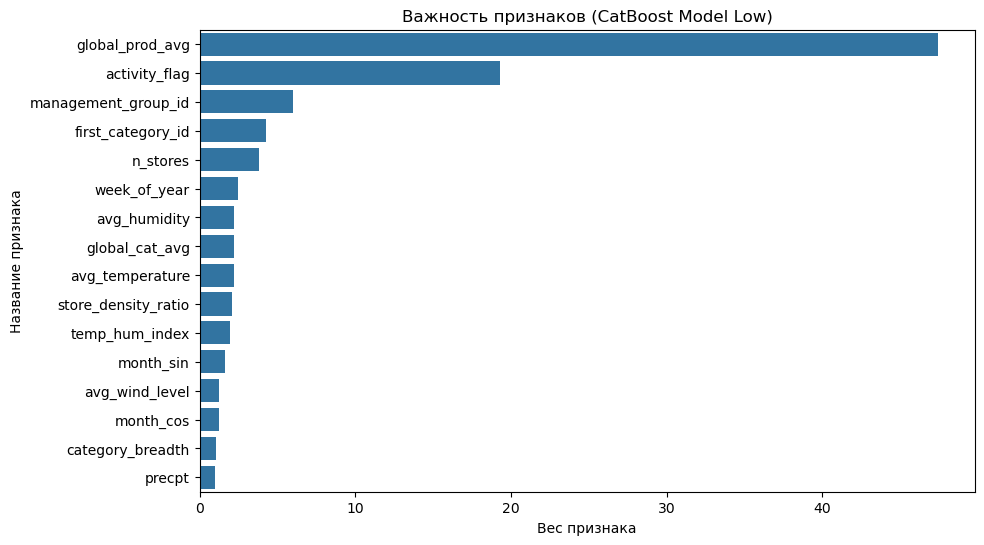

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

In [4]:
# попробовать нейронку на поиск аномалий адаптировать под регрессию


In [7]:
import optuna
from optuna.samplers import TPESampler

In [8]:
# def objective(trial):
#     # 1. Параметры для подбора
#     params = {
#         'iterations': 3000, # Используем early_stopping, так что можно ставить с запасом
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#         'random_strength': trial.suggest_float('random_strength', 0.1, 2.0),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
#         'random_seed': SEED,
#         'verbose': False,
#         'early_stopping_rounds': 100,
#         'loss_function': 'MAE',
#         'task_type': 'CPU', # Смените на GPU, если есть возможность
#     }

#     # 2. Обучаем модели для p05 и p95 на валидационном сплите
#     # Мы оптимизируем средний IoU для обоих границ сразу
    
#     m_low = CatBoostRegressor(**params)
#     m_low.fit(train_part[features], train_part['price_p05'], 
#               eval_set=(val_part[features], val_part['price_p05']),
#               cat_features=cat_features)
    
#     m_high = CatBoostRegressor(**params)
#     m_high.fit(train_part[features], train_part['price_p95'], 
#                eval_set=(val_part[features], val_part['price_p95']),
#                cat_features=cat_features)

#     # 3. Предсказание на валидации
#     p05_pred = m_low.predict(val_part[features])
#     p95_pred = m_high.predict(val_part[features])
    
#     # Гарантируем корректность границ
#     p95_pred = np.maximum(p95_pred, p05_pred + 1e-3)

#     # 4. Считаем метрику IoU
#     score = calculate_iou(
#         val_part['price_p05'].values, 
#         val_part['price_p95'].values, 
#         p05_pred, 
#         p95_pred
#     )
    
#     return score

# # Создаем исследование
# study = optuna.create_study(
#     direction='maximize', 
#     sampler=TPESampler(seed=SEED)
# )

# # Запуск на 10 часов (36000 секунд)
# print("Начало оптимизации Optuna...")
# study.optimize(objective, n_trials=None, timeout=36000) 

# print(f"Лучший IoU: {study.best_value}")
# print(f"Лучшие параметры: {study.best_params}")

[I 2025-12-20 21:08:23,446] A new study created in memory with name: no-name-e5cd8312-12f1-4170-b0cc-676abccadceb


Начало оптимизации Optuna...


[I 2025-12-20 21:08:53,023] Trial 0 finished with value: 0.21820625000990063 and parameters: {'learning_rate': 0.017208446523592307, 'depth': 4, 'l2_leaf_reg': 3.484403615988005, 'random_strength': 0.41671313751926886, 'bagging_temperature': 0.017414696212477043}. Best is trial 0 with value: 0.21820625000990063.
[I 2025-12-20 21:09:15,626] Trial 1 finished with value: 0.22034961446813014 and parameters: {'learning_rate': 0.028242019234027114, 'depth': 5, 'l2_leaf_reg': 1.9667922615118174, 'random_strength': 0.4371356204189485, 'bagging_temperature': 0.22816260987992754}. Best is trial 1 with value: 0.22034961446813014.
[I 2025-12-20 21:09:30,385] Trial 2 finished with value: 0.2185243475758169 and parameters: {'learning_rate': 0.09627921106281245, 'depth': 4, 'l2_leaf_reg': 9.549857100177304, 'random_strength': 0.4361409170566486, 'bagging_temperature': 0.12189568646068749}. Best is trial 1 with value: 0.22034961446813014.
[I 2025-12-20 21:09:41,263] Trial 3 finished with value: 0.2224

Лучший IoU: 0.22688829952438236
Лучшие параметры: {'learning_rate': 0.09981859399773757, 'depth': 7, 'l2_leaf_reg': 8.533654459953857, 'random_strength': 1.3535330397123693, 'bagging_temperature': 0.757231412091197}


In [ ]:
# Лучший IoU: 0.22688829952438236
# Лучшие параметры: {'learning_rate': 0.09981859399773757, 'depth': 7, 'l2_leaf_reg': 8.533654459953857, 'random_strength': 1.3535330397123693, 'bagging_temperature': 0.757231412091197}

In [9]:
# # 6. ФИНАЛЬНОЕ ОБУЧЕНИЕ С ЛУЧШИМИ ПАРАМЕТРАМИ
# print("Обучение финальных моделей на найденных гиперпараметрах...")

# best_params = study.best_params
# best_params.update({'random_seed': SEED, 'loss_function': 'MAE', 'verbose': 100})

# # Для финального обучения на всем датасете нужно определить кол-во итераций.
# # Можно взять среднее из логов Optuna или просто зафиксировать большое число.
# final_low = CatBoostRegressor(**best_params, iterations=2500)
# final_high = CatBoostRegressor(**best_params, iterations=2500)

# final_low.fit(train[features], train['price_p05'], cat_features=cat_features)
# final_high.fit(train[features], train['price_p95'], cat_features=cat_features)

Обучение финальных моделей на найденных гиперпараметрах...
0:	learn: 0.1411025	total: 26.2ms	remaining: 1m 5s
100:	learn: 0.0869198	total: 2.48s	remaining: 58.9s
200:	learn: 0.0832549	total: 5.04s	remaining: 57.7s
300:	learn: 0.0807746	total: 7.69s	remaining: 56.2s
400:	learn: 0.0787971	total: 10.2s	remaining: 53.4s
500:	learn: 0.0772113	total: 12.7s	remaining: 50.7s
600:	learn: 0.0759522	total: 15.2s	remaining: 48.1s
700:	learn: 0.0748250	total: 17.7s	remaining: 45.5s
800:	learn: 0.0738005	total: 20.2s	remaining: 42.9s
900:	learn: 0.0729035	total: 22.9s	remaining: 40.6s
1000:	learn: 0.0721516	total: 25.4s	remaining: 38s
1100:	learn: 0.0714738	total: 27.9s	remaining: 35.4s
1200:	learn: 0.0708989	total: 30.3s	remaining: 32.8s
1300:	learn: 0.0703494	total: 32.8s	remaining: 30.2s
1400:	learn: 0.0697776	total: 35.3s	remaining: 27.7s
1500:	learn: 0.0692779	total: 37.9s	remaining: 25.2s
1600:	learn: 0.0687586	total: 40.5s	remaining: 22.7s
1700:	learn: 0.0683587	total: 42.9s	remaining: 20.2s
